In [133]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, cross_validate, train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from scipy.stats import kurtosis
from sklearn import random_projection
from scipy.linalg import pinv
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.manifold import TSNE

In [134]:
#load data
df = pd.read_csv(r'./credit.csv')

In [135]:
# Cleaning data

df = df.drop('ID', axis=1)
fil = (df.EDUCATION == 5) | (df.EDUCATION == 6) | (df.EDUCATION == 0)
df.loc[fil, 'EDUCATION'] = 4
df.EDUCATION.value_counts()
df.loc[df.MARRIAGE == 0, 'MARRIAGE'] = 3
df.MARRIAGE.value_counts()
df = df.rename(columns={'PAY_0':'PAY_1'})
fil = (df.PAY_1 == -2) | (df.PAY_1 == -1) | (df.PAY_1 == 0)
df.loc[fil, 'PAY_1'] = 0 
fil = (df.PAY_2 == -2) | (df.PAY_2 == -1) | (df.PAY_2 == 0)
df.loc[fil, 'PAY_2'] = 0
fil = (df.PAY_3 == -2) | (df.PAY_3 == -1) | (df.PAY_3 == 0)
df.loc[fil, 'PAY_3'] = 0
fil = (df.PAY_4 == -2) | (df.PAY_4 == -1) | (df.PAY_4 == 0)
df.loc[fil, 'PAY_4'] = 0
fil = (df.PAY_5 == -2) | (df.PAY_5 == -1) | (df.PAY_5 == 0)
df.loc[fil, 'PAY_5'] = 0
fil = (df.PAY_6 == -2) | (df.PAY_6 == -1) | (df.PAY_6 == 0)
df.loc[fil, 'PAY_6'] = 0
df = df.rename(columns={'default payment next month':'default'})
fil = (df.PAY_1 == 0) & (df.PAY_2 == 0) & (df.PAY_3 == 0) & (df.PAY_4 == 0) & (df.PAY_5 == 0) & (df.PAY_6 == 0) & (df.default ==1)
df.loc[fil,'default'] = 0
fil = (df.PAY_1 > 0) & (df.PAY_2 > 0) & (df.PAY_3 > 0) & (df.PAY_4 > 0) & (df.PAY_5 > 0) & (df.PAY_6 > 0) & (df.default ==0)
df.loc[fil,'default'] = 1

In [136]:
y = df.pop('default')
#scale features
X_scaled = preprocessing.scale(df)

#split train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

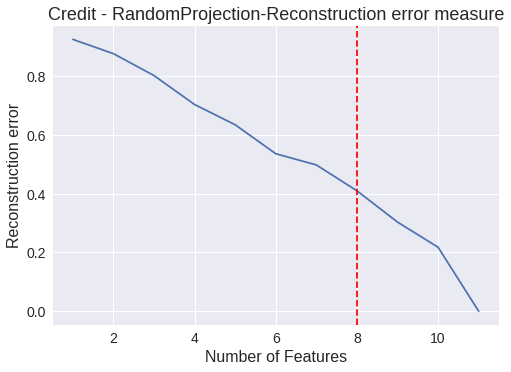

In [137]:
#randomized projection
n_features = X_train.shape[1]
error_list = []
for feature in range(1,n_features+1):
    transformer = random_projection.GaussianRandomProjection(n_components=feature,random_state=42)
    X_reduced = transformer.fit_transform(X_train)
    W = transformer.components_.T
    p = pinv(W)
    reconstructed_matrix = X_reduced.dot(p)
    error = np.mean(np.square(reconstructed_matrix-X_train))
    error_list.append(error)
plt.style.use('seaborn')
plt.plot(range(1,n_features+1),error_list)
plt.xlabel('Number of Features', fontsize = 16)
plt.ylabel('Reconstruction error', fontsize = 16)
#plt.legend(fontsize=16)
plt.title('Credit - RandomProjection-Reconstruction error measure', fontsize = 18)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
#plt.ylim(20000,35000)
plt.axvline(x=8,color='r', linestyle='--')
plt.show()

In [138]:
#use 8 components based on above tests
transformer = random_projection.GaussianRandomProjection(n_components=8,random_state=42)
X_reduced = transformer.fit_transform(X_train)

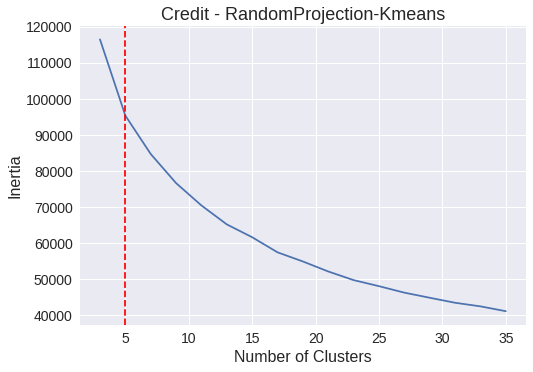

In [139]:
#find best kmeans on pca data using elbow method
cluster_range = [3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35]
#mean squared distance between each instance and its closest centroid. Also called inertia
msd = []
for num_cluster in cluster_range:
    c = KMeans(n_clusters=num_cluster, random_state=1)
    #apply kmeans on pca data
    c_labels = c.fit(X_reduced)
    msd.append(c.inertia_)
plt.style.use('seaborn')
plt.plot([3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35],msd)
plt.xlabel('Number of Clusters', fontsize = 16)
plt.ylabel('Inertia', fontsize = 16)
plt.title('Credit - RandomProjection-Kmeans', fontsize = 18)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.axvline(x=5,color='r', linestyle='--')
plt.show()

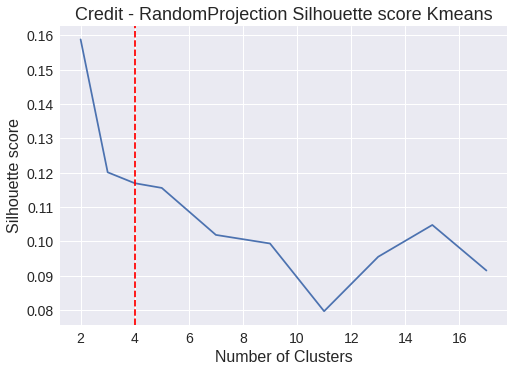

In [95]:
#find best kmeans on pca data using silhouette method
cluster_range = [2,3,4,5,7,9,11,13,15,17]
#mean squared distance between each instance and its closest centroid. Also called inertia
silhouette_list = []
for num_cluster in cluster_range:
    c = KMeans(n_clusters=num_cluster, random_state=10)
    c_labels = c.fit_predict(X_reduced)
    silhouette_list.append(silhouette_score(X_train, c_labels))
plt.style.use('seaborn')
plt.plot([2,3,4,5,7,9,11,13,15,17],silhouette_list)
plt.xlabel('Number of Clusters', fontsize = 16)
plt.ylabel('Silhouette score', fontsize = 16)
plt.title('Credit - RandomProjection Silhouette score Kmeans', fontsize = 18)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.axvline(x=4,color='r', linestyle='--')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.23621469941241555
For n_clusters = 3 The average silhouette_score is : 0.19570898612765275
For n_clusters = 4 The average silhouette_score is : 0.19688218223622167
For n_clusters = 5 The average silhouette_score is : 0.18610582661557282
For n_clusters = 6 The average silhouette_score is : 0.17158610859382345
For n_clusters = 7 The average silhouette_score is : 0.18750273428134023
For n_clusters = 8 The average silhouette_score is : 0.1864000618931578


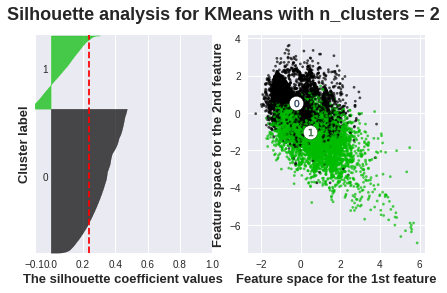

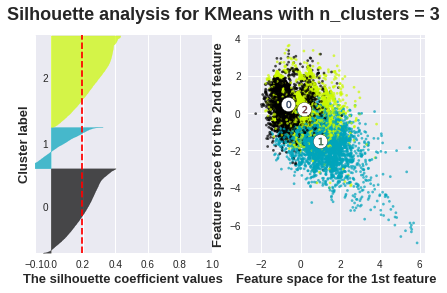

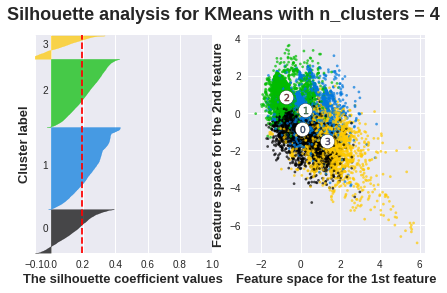

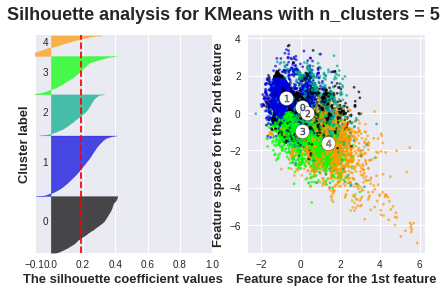

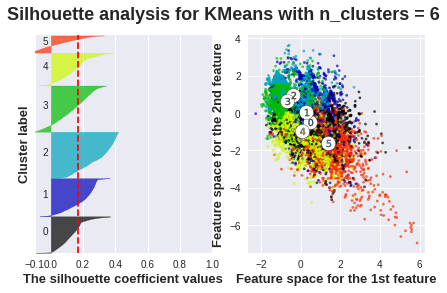

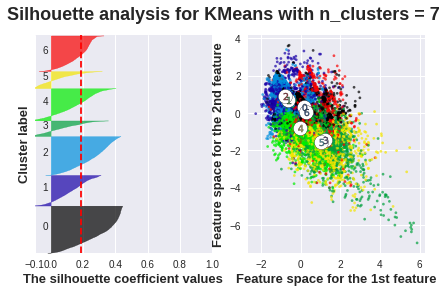

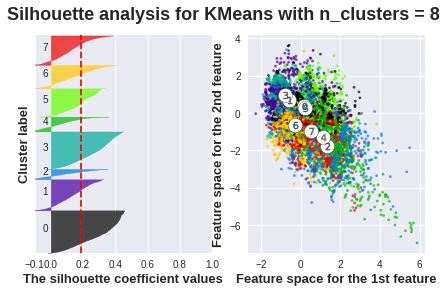

In [96]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
range_n_clusters = [2, 3, 4, 5, 6,7,8]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(7, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_train) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_reduced)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_reduced, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_reduced, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values",fontsize=13,fontweight='bold')
    ax1.set_ylabel("Cluster label",fontsize=13,fontweight='bold')

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_reduced[:, 0], X_reduced[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    #ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature",fontsize=13,fontweight='bold')
    ax2.set_ylabel("Feature space for the 2nd feature",fontsize=13,fontweight='bold')

    plt.suptitle(("Silhouette analysis for KMeans "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=18, fontweight='bold')

plt.show()

In [126]:
#use 8 clusters based on above tests
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans_labels = kmeans.fit(X_reduced)

In [127]:
def convert_numarr_to_df_pca (X_train,y_train,features):
    #convert back X_train to df for visulaization
    rows = X_train.shape[0]
    col_list = []
    #target = np.reshape(y_train.to_numpy(),(rows,1))
    target = np.reshape(y_train,(rows,1))
    X_train_vis = np.hstack((X_train,target))
    for i in range(1,features+1):
        col_list.append('component_' + str(i))
    #col_list = list(df.columns)
    col_list.append('quality')
    df_vis = pd.DataFrame(data=X_train_vis,    # values
            #index=data[1:,0],    # 1st column as index
            columns=col_list)
    return df_vis

In [128]:
df_vis_rp_credit = convert_numarr_to_df_pca(X_reduced,kmeans_labels.labels_,X_reduced.shape[1])

In [129]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300,random_state=10)
tsne_results = tsne.fit_transform(df_vis_rp_credit)

df_vis_rp_credit['tsne-2d-one'] = tsne_results[:,0]
df_vis_rp_credit['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(8,4))
sns.scatterplot(
    x="tsne-2d-one",
    y="tsne-2d-two",
    hue="quality",
    palette=sns.color_palette("hls",4),
    data=df_vis_rp_wine,
    legend="full",
    alpha=0.3
)
plt.title('Credit-4 clusters for kmeans based on RandomProjection', fontsize = 14)
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 24000 samples in 0.034s...
[t-SNE] Computed neighbors for 24000 samples in 3.089s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24000
[t-SNE] Computed conditional probabilities for sample 2000 / 24000
[t-SNE] Computed conditional probabilities for sample 3000 / 24000
[t-SNE] Computed conditional probabilities for sample 4000 / 24000
[t-SNE] Computed conditional probabilities for sample 5000 / 24000
[t-SNE] Computed conditional probabilities for sample 6000 / 24000
[t-SNE] Computed conditional probabilities for sample 7000 / 24000
[t-SNE] Computed conditional probabilities for sample 8000 / 24000
[t-SNE] Computed conditional probabilities for sample 9000 / 24000
[t-SNE] Computed conditional probabilities for sample 10000 / 24000
[t-SNE] Computed conditional probabilities for sample 11000 / 24000
[t-SNE] Computed conditional probabilities for sample 12000 / 24000
[t-SNE] Computed conditional probabilities for sa

ValueError: Could not interpret value `quality` for parameter `hue`

<Figure size 576x288 with 0 Axes>

AIC for n_clusters(3): [450278.2947610025]
BIC for n_clusters(3): [450682.58521646896]
AIC for n_clusters(5): [450278.2947610025, 414701.4528699942]
BIC for n_clusters(5): [450682.58521646896, 415380.6608351779]
AIC for n_clusters(6): [450278.2947610025, 414701.4528699942, 397784.8626871396]
BIC for n_clusters(6): [450682.58521646896, 415380.6608351779, 398601.52940718195]
AIC for n_clusters(7): [450278.2947610025, 414701.4528699942, 397784.8626871396, 381010.9381864336]
BIC for n_clusters(7): [450682.58521646896, 415380.6608351779, 398601.52940718195, 381965.0636613345]
AIC for n_clusters(9): [450278.2947610025, 414701.4528699942, 397784.8626871396, 381010.9381864336, 363999.07183597004]
BIC for n_clusters(9): [450682.58521646896, 415380.6608351779, 398601.52940718195, 381965.0636613345, 365228.1148205882]
AIC for n_clusters(11): [450278.2947610025, 414701.4528699942, 397784.8626871396, 381010.9381864336, 363999.07183597004, 343958.3578751083]
BIC for n_clusters(11): [450682.585216468

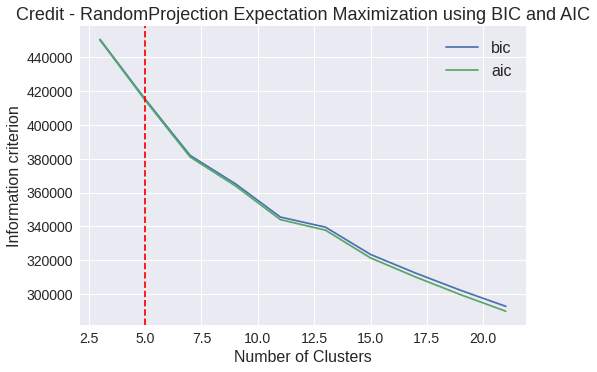

In [101]:
#Refer to last page which explains why AIC and BIC can be different.
#Basically more the number of clusters, more the number of gaussian distributions
#and more the number of parameters. Based on the increased number of parameters,
#bic is penalized which causes bic value to increase.
cluster_range = [3,5,6,7,9,11,13,15,17,19,21]
bic = []
aic = []
for num_cluster in cluster_range:
    gmm = GaussianMixture(covariance_type = 'diag', n_components = num_cluster, n_init = 10,random_state=1)
    c_labels = gmm.fit(X_reduced)
    bic.append(gmm.bic(X_reduced))
    aic.append(gmm.aic(X_reduced))
    print('AIC for n_clusters(%s): %s'%(num_cluster, aic))
    print('BIC for n_clusters(%s): %s'%(num_cluster, bic))
    
plt.style.use('seaborn')
plt.plot([3,5,6,7,9,11,13,15,17,19,21],bic,label = 'bic')
plt.plot([3,5,6,7,9,11,13,15,17,19,21],aic,label = 'aic')
plt.xlabel('Number of Clusters', fontsize = 16)
plt.ylabel('Information criterion', fontsize = 16)
plt.legend(fontsize=16)
plt.title('Credit - RandomProjection Expectation Maximization using BIC and AIC', fontsize = 18)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.axvline(x=5,color='r', linestyle='--')
#plt.ylim(20000,35000)
plt.show()

In [146]:
gmm = GaussianMixture(covariance_type = 'diag', n_components = 5, n_init = 10,random_state=1)
gmm_c_labels = gmm.fit(X_reduced)

In [147]:
df_vis_gmm_rp_credit = convert_numarr_to_df_pca(X_reduced,gmm_c_labels.predict(X_reduced),X_reduced.shape[1])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 24000 samples in 0.039s...
[t-SNE] Computed neighbors for 24000 samples in 3.196s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24000
[t-SNE] Computed conditional probabilities for sample 2000 / 24000
[t-SNE] Computed conditional probabilities for sample 3000 / 24000
[t-SNE] Computed conditional probabilities for sample 4000 / 24000
[t-SNE] Computed conditional probabilities for sample 5000 / 24000
[t-SNE] Computed conditional probabilities for sample 6000 / 24000
[t-SNE] Computed conditional probabilities for sample 7000 / 24000
[t-SNE] Computed conditional probabilities for sample 8000 / 24000
[t-SNE] Computed conditional probabilities for sample 9000 / 24000
[t-SNE] Computed conditional probabilities for sample 10000 / 24000
[t-SNE] Computed conditional probabilities for sample 11000 / 24000
[t-SNE] Computed conditional probabilities for sample 12000 / 24000
[t-SNE] Computed conditional probabilities for sa

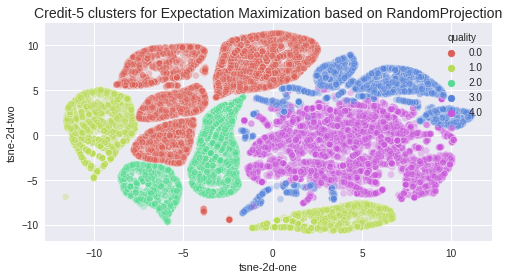

In [148]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300,random_state=42)
tsne_results = tsne.fit_transform(df_vis_gmm_rp_credit)

df_vis_gmm_rp_credit['tsne-2d-one'] = tsne_results[:,0]
df_vis_gmm_rp_credit['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(8,4))
sns.scatterplot(
    x="tsne-2d-one",
    y="tsne-2d-two",
    hue="quality",
    palette=sns.color_palette("hls", 5),
    data=df_vis_gmm_rp_credit,
    legend="full",
    alpha=0.3
)
plt.title('Credit-5 clusters for Expectation Maximization based on RandomProjection', fontsize = 14)
plt.show()

In [149]:
#load data
df = pd.read_csv(r'./wine.csv')

y = df.pop('class')
#scale features
X_scaled = preprocessing.scale(df)

#split train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

In [150]:
#scale features
X_scaled = preprocessing.scale(df)

#oversample = BorderlineSMOTE(random_state=42)
#X_scaled, y = oversample.fit_resample(X_scaled, y)


#split train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)


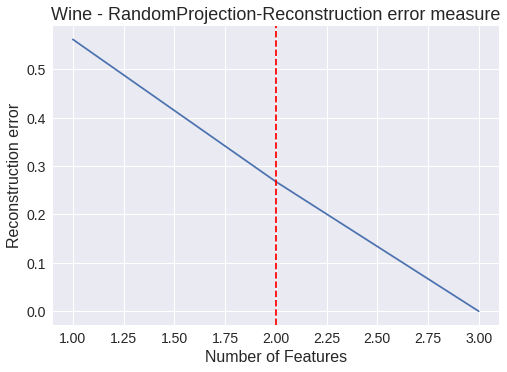

In [151]:
#randomized projection
n_features = X_train.shape[1]
error_list = []
for feature in range(1,n_features+1):
    transformer = random_projection.GaussianRandomProjection(n_components=feature,random_state=42)
    X_reduced = transformer.fit_transform(X_train)
    W = transformer.components_.T
    p = pinv(W)
    reconstructed_matrix = X_reduced.dot(p)
    error = np.mean(np.square(reconstructed_matrix-X_train))
    error_list.append(error)
plt.style.use('seaborn')
plt.plot(range(1,n_features+1),error_list)
plt.xlabel('Number of Features', fontsize = 16)
plt.ylabel('Reconstruction error', fontsize = 16)
#plt.legend(fontsize=16)
plt.title('Wine - RandomProjection-Reconstruction error measure', fontsize = 18)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
#plt.ylim(20000,35000)
plt.axvline(x=2,color='r', linestyle='--')
plt.show()

In [105]:
#use 2 components based on above tests
transformer = random_projection.GaussianRandomProjection(n_components=2,random_state=10)
X_reduced = transformer.fit_transform(X_train)

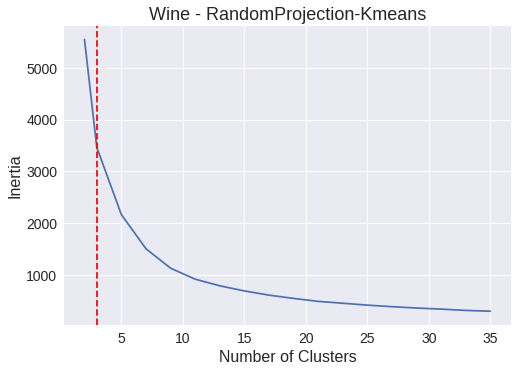

In [106]:
#find best kmeans on pca data using elbow method
cluster_range = [2,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35]
#mean squared distance between each instance and its closest centroid. Also called inertia
msd = []
for num_cluster in cluster_range:
    c = KMeans(n_clusters=num_cluster, random_state=10)
    #apply kmeans on pca data
    c_labels = c.fit(X_reduced)
    msd.append(c.inertia_)
plt.style.use('seaborn')
plt.plot([2,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35],msd)
plt.xlabel('Number of Clusters', fontsize = 16)
plt.ylabel('Inertia', fontsize = 16)
plt.title('Wine - RandomProjection-Kmeans', fontsize = 18)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.axvline(x=3,color='r', linestyle='--')
plt.show()

[0.21279691446896457]
[0.21279691446896457, 0.13628050106459466]
[0.21279691446896457, 0.13628050106459466, 0.09240985180202123]
[0.21279691446896457, 0.13628050106459466, 0.09240985180202123, 0.13778209483537754]
[0.21279691446896457, 0.13628050106459466, 0.09240985180202123, 0.13778209483537754, 0.10943952311881612]
[0.21279691446896457, 0.13628050106459466, 0.09240985180202123, 0.13778209483537754, 0.10943952311881612, 0.08288176845361923]
[0.21279691446896457, 0.13628050106459466, 0.09240985180202123, 0.13778209483537754, 0.10943952311881612, 0.08288176845361923, 0.06272774871317036]
[0.21279691446896457, 0.13628050106459466, 0.09240985180202123, 0.13778209483537754, 0.10943952311881612, 0.08288176845361923, 0.06272774871317036, 0.054181336837320966]
[0.21279691446896457, 0.13628050106459466, 0.09240985180202123, 0.13778209483537754, 0.10943952311881612, 0.08288176845361923, 0.06272774871317036, 0.054181336837320966, 0.05114279103238911]
[0.21279691446896457, 0.13628050106459466, 0

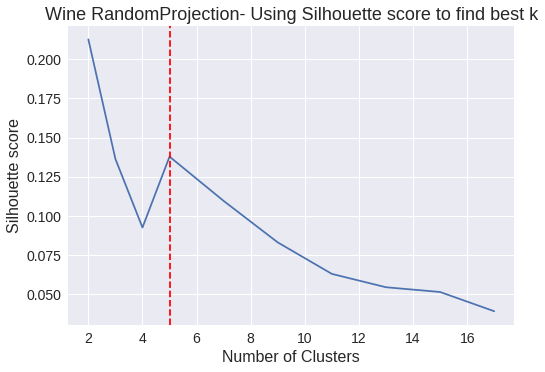

In [108]:
#find best kmeans on pca data using silhouette method
cluster_range = [2,3,4,5,7,9,11,13,15,17]
#mean squared distance between each instance and its closest centroid. Also called inertia
silhouette_list = []
for num_cluster in cluster_range:
    c = KMeans(n_clusters=num_cluster, random_state=42)
    c_labels = c.fit_predict(X_reduced)
    silhouette_list.append(silhouette_score(X_train, c_labels))
    print(silhouette_list)    
plt.style.use('seaborn')
plt.plot([2,3,4,5,7,9,11,13,15,17],silhouette_list)
plt.xlabel('Number of Clusters', fontsize = 16)
plt.ylabel('Silhouette score', fontsize = 16)
plt.title('Wine RandomProjection- Using Silhouette score to find best k', fontsize = 18)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.axvline(x=5,color='r', linestyle='--')
plt.show()

In [152]:
kmeans = KMeans(n_clusters=5, random_state=1)
kmeans_labels = kmeans.fit(X_reduced)

In [153]:
def convert_numarr_to_df_pca (X_train,y_train,features):
    #convert back X_train to df for visulaization
    rows = X_train.shape[0]
    col_list = []
    #target = np.reshape(y_train.to_numpy(),(rows,1))
    target = np.reshape(y_train,(rows,1))
    X_train_vis = np.hstack((X_train,target))
    for i in range(1,features+1):
        col_list.append('component_' + str(i))
    #col_list = list(df.columns)
    col_list.append('class')
    df_vis = pd.DataFrame(data=X_train_vis,    # values
            #index=data[1:,0],    # 1st column as index
            columns=col_list)
    return df_vis

In [154]:
df_vis_rp_wine = convert_numarr_to_df_pca(X_reduced,kmeans_labels.labels_,X_reduced.shape[1])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5197 samples in 0.006s...
[t-SNE] Computed neighbors for 5197 samples in 0.219s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5197
[t-SNE] Computed conditional probabilities for sample 2000 / 5197
[t-SNE] Computed conditional probabilities for sample 3000 / 5197
[t-SNE] Computed conditional probabilities for sample 4000 / 5197
[t-SNE] Computed conditional probabilities for sample 5000 / 5197
[t-SNE] Computed conditional probabilities for sample 5197 / 5197
[t-SNE] Mean sigma: 0.123095
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.594810
[t-SNE] KL divergence after 300 iterations: 1.493288


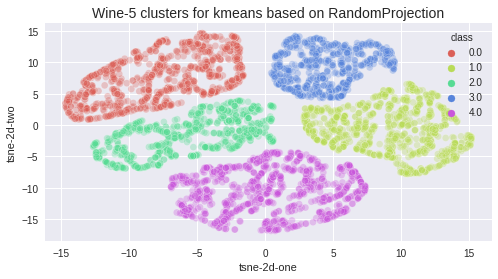

In [155]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300,random_state=42)
tsne_results = tsne.fit_transform(df_vis_rp_wine)

df_vis_rp_wine['tsne-2d-one'] = tsne_results[:,0]
df_vis_rp_wine['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(8,4))
sns.scatterplot(
    x="tsne-2d-one",
    y="tsne-2d-two",
    hue="class",
    palette=sns.color_palette("hls", 5),
    data=df_vis_rp_wine,
    legend="full",
    alpha=0.3
)
plt.title('Wine-5 clusters for kmeans based on RandomProjection', fontsize = 14)
plt.show()

AIC for n_clusters(3): [25885.604349722493]
BIC for n_clusters(3): [25997.053575577636]
AIC for n_clusters(5): [25885.604349722493, 25277.243839969728]
BIC for n_clusters(5): [25997.053575577636, 25467.36310760497]
AIC for n_clusters(6): [25885.604349722493, 25277.243839969728, 25303.958381486176]
BIC for n_clusters(6): [25997.053575577636, 25467.36310760497, 25533.412670011472]
AIC for n_clusters(7): [25885.604349722493, 25277.243839969728, 25303.958381486176, 25293.510848506216]
BIC for n_clusters(7): [25997.053575577636, 25467.36310760497, 25533.412670011472, 25562.300157921563]
AIC for n_clusters(9): [25885.604349722493, 25277.243839969728, 25303.958381486176, 25293.510848506216, 25314.88333916104]
BIC for n_clusters(9): [25997.053575577636, 25467.36310760497, 25533.412670011472, 25562.300157921563, 25662.342690356487]
AIC for n_clusters(11): [25885.604349722493, 25277.243839969728, 25303.958381486176, 25293.510848506216, 25314.88333916104, 25258.19270987104]
BIC for n_clusters(11)

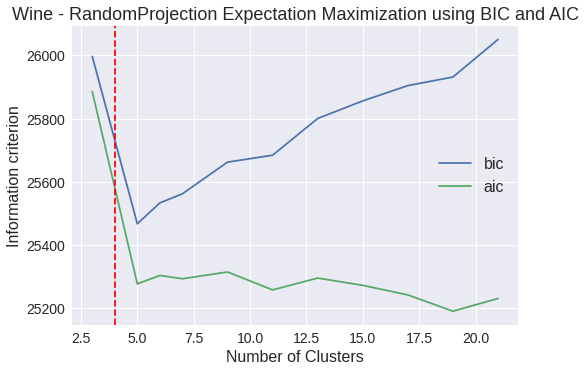

In [115]:
#Refer to last page which explains why AIC and BIC can be different.
#Basically more the number of clusters, more the number of gaussian distributions
#and more the number of parameters. Based on the increased number of parameters,
#bic is penalized which causes bic value to increase.
cluster_range = [3,5,6,7,9,11,13,15,17,19,21]
bic = []
aic = []
for num_cluster in cluster_range:
    gmm = GaussianMixture(covariance_type = 'full', n_components = num_cluster, n_init = 10,random_state=1)
    c_labels = gmm.fit(X_reduced)
    bic.append(gmm.bic(X_reduced))
    aic.append(gmm.aic(X_reduced))
    print('AIC for n_clusters(%s): %s'%(num_cluster, aic))
    print('BIC for n_clusters(%s): %s'%(num_cluster, bic))
plt.style.use('seaborn')
plt.plot([3,5,6,7,9,11,13,15,17,19,21],bic,label = 'bic')
plt.plot([3,5,6,7,9,11,13,15,17,19,21],aic,label = 'aic')
plt.xlabel('Number of Clusters', fontsize = 16)
plt.ylabel('Information criterion', fontsize = 16)
plt.legend(fontsize=16)
plt.title('Wine - RandomProjection Expectation Maximization using BIC and AIC', fontsize = 18)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.axvline(x=4,color='r', linestyle='--')
#plt.ylim(20000,35000)
plt.show()

In [116]:
gmm = GaussianMixture(covariance_type = 'diag', n_components = 5, n_init = 10,random_state=1)
gmm_c_labels = gmm.fit(X_reduced)

In [117]:
df_vis_gmm_rp_wine = convert_numarr_to_df_pca(X_reduced,gmm_c_labels.predict(X_reduced),X_reduced.shape[1])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5197 samples in 0.008s...
[t-SNE] Computed neighbors for 5197 samples in 0.223s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5197
[t-SNE] Computed conditional probabilities for sample 2000 / 5197
[t-SNE] Computed conditional probabilities for sample 3000 / 5197
[t-SNE] Computed conditional probabilities for sample 4000 / 5197
[t-SNE] Computed conditional probabilities for sample 5000 / 5197
[t-SNE] Computed conditional probabilities for sample 5197 / 5197
[t-SNE] Mean sigma: 0.780242
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.974770
[t-SNE] KL divergence after 300 iterations: 1.201317


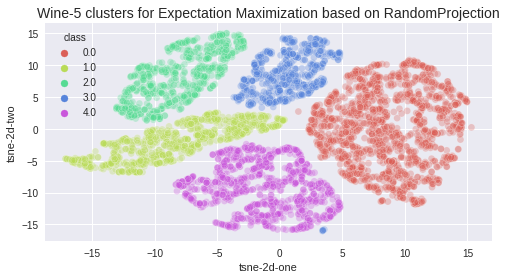

In [118]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300,random_state=10)
tsne_results = tsne.fit_transform(df_vis_gmm_rp_diabetes)

df_vis_gmm_rp_wine['tsne-2d-one'] = tsne_results[:,0]
df_vis_gmm_rp_wine['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(8,4))
sns.scatterplot(
    x="tsne-2d-one",
    y="tsne-2d-two",
    hue="class",
    palette=sns.color_palette("hls", 5),
    data=df_vis_gmm_rp_diabetes,
    legend="full",
    alpha=0.3
)
plt.title('Wine-5 clusters for Expectation Maximization based on RandomProjection', fontsize = 14)
plt.show()